In [1]:
from keras.datasets import mnist
import numpy as np

%matplotlib inline

from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5

X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)


Using TensorFlow backend.


In [2]:
# print(y_train)
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

y_train = encode(y_train)
y_test = encode(y_test)

print(y_train)
print(y_test)


Shape of data (BEFORE encode): (60000,)
Shape of data (AFTER  encode): (60000, 10)

Shape of data (BEFORE encode): (10000,)
Shape of data (AFTER  encode): (10000, 10)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:

def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1


In [6]:
# (re-)load layers
%run homework_modules.ipynb


In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]


In [9]:
def train(net, X_train, y_train, isPrint=False):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
            net.zeroGradParameters()
        
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            loss_history.append(loss)
            if isPrint:
                print(loss)
            
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()


In [10]:
# (re-)load layers
%run homework_modules.ipynb


In [11]:

net = Sequential()
net.add(Linear(28 * 28, 14 * 14))
net.add(LeakyReLU())
net.add(Dropout())
net.add(Linear(14* 14, 7 * 7))
net.add(LeakyReLU())
net.add(Linear(7 * 7, 10))
net.add(LeakyReLU())

criterion = MSECriterion()


Train ....


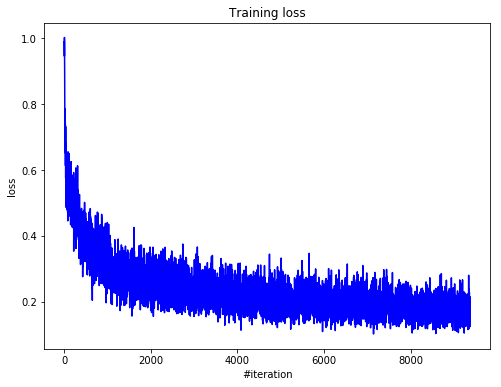

In [12]:
print("Train ....")
train(net, X_train, y_train)
